In [1]:
#Importing the required libraries
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import tree

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("BigMartTrain.csv")
df_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
df_test = pd.read_csv("BigMartTest.csv")
df_test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [5]:
df_train.shape

(8523, 12)

In [6]:
#Checking the Missing Values
df_train.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [7]:
#Filling the Missing Values of Item_Weight by median() and Outlet_Size() by mode()
df_train["Item_Weight"].fillna(df_train["Item_Weight"].median(), inplace=True)
df_train["Outlet_Size"].fillna(df_train["Outlet_Size"].mode()[0], inplace=True)

In [8]:
df_train.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [9]:
#Feature Engineering
# creating a broad category of type of Items
df_train['Item_Type_Combined'] = df_train['Item_Identifier'].apply(lambda df_train: df_train[0:2])
df_train['Item_Type_Combined'] = df_train['Item_Type_Combined'].map({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'})

df_train['Item_Type_Combined'].value_counts()

# operating years of the store
df_train['Outlet_Years'] = 2013 - df_train['Outlet_Establishment_Year']

# modifying categories of Item_Fat_Content
df_train['Item_Fat_Content'] = df_train['Item_Fat_Content'].replace({'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'})
df_train['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [10]:
# Data Pre-processing
# label encoding the ordinal variables
le = LabelEncoder()
df_train['Outlet'] = le.fit_transform(df_train['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    df_train[i] = le.fit_transform(df_train[i])

# one hot encoding the remaining categorical variables 
df_train = pd.get_dummies(df_train, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])

In [11]:
#Train Test Split
# dropping the ID variables and variables that have been used to extract new variables
df_train.drop(['Item_Type','Outlet_Establishment_Year', 'Item_Identifier', 'Outlet_Identifier'],axis=1,inplace=True)

# separating the dependent and independent variables
X = df_train.drop('Item_Outlet_Sales',1)
y = df_train['Item_Outlet_Sales']

# creating the training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [12]:
# Initialize SHAP
# Need to load JS vis in the notebook
shap.initjs()

In [13]:
#Fitting XGBoost
xgb_model = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001, random_state=0)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.001, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [14]:
#Generating Predictions
y_predict = xgb_model.predict(X_test)

In [15]:
#Evaluating Performance
mean_squared_error(y_test, y_predict)**(0.5)

1394.5361315728821

In [16]:
#Local Interpretation using SHAP (for prediction at id number 4776)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)
i = 4776
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train.loc[4776], feature_names=X_train.columns)

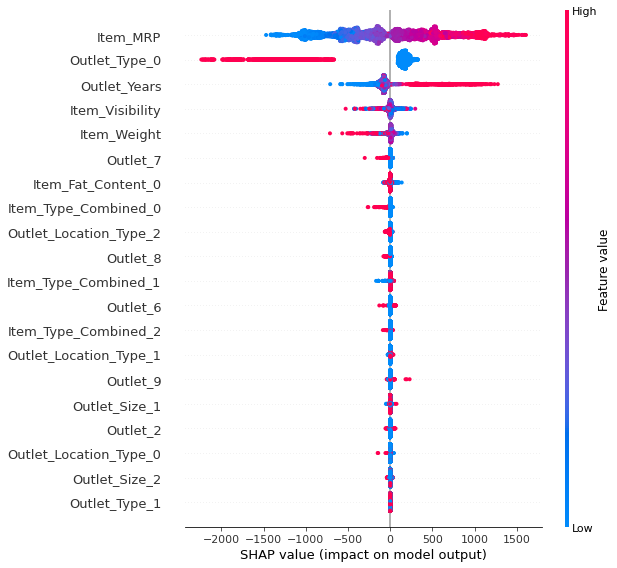

In [17]:
#Global Interpretation using Shapley Values
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

In [18]:
df_train.tail()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Outlet_Years,Item_Fat_Content_0,Item_Fat_Content_1,Outlet_Location_Type_0,Outlet_Location_Type_1,Outlet_Location_Type_2,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
8518,6.865,0.056783,214.5218,2778.3834,26,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
8519,8.380,0.046982,108.1570,549.2850,11,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
8520,10.600,0.035186,85.1224,1193.1136,9,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
8521,7.210,0.145221,103.1332,1845.5976,4,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
8522,14.800,0.044878,75.4670,765.6700,16,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [19]:
#Local Interpretation using SHAP (for prediction at id number )
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)
i = 5000
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train.loc[5000], feature_names=X_train.columns)

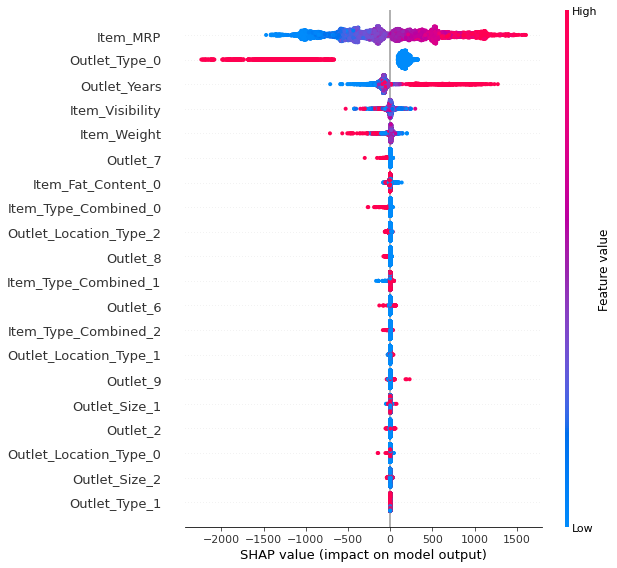

In [20]:
#Global Interpretation using Shapley Values
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

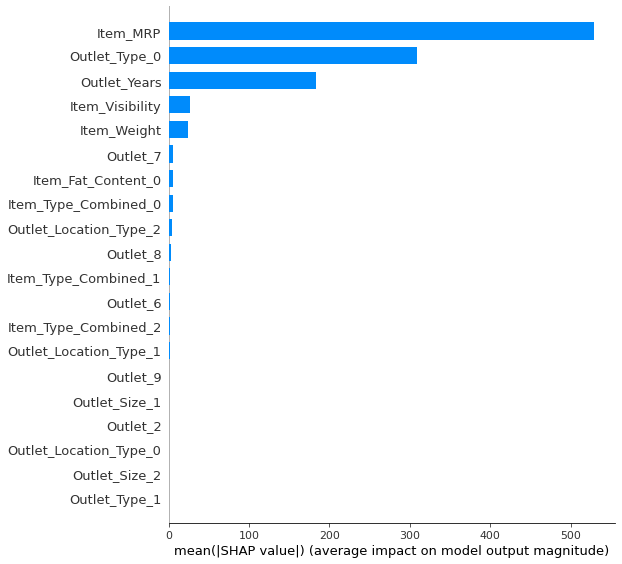

In [21]:
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_train, plot_type='bar')